In [1]:
import os
import json
import cv2
from shutil import copyfile
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

import sys
par_dir = ! cd .. && pwd
sys.path.append(par_dir[0])

from utils.court import load_court_mask, load_court_poi, generate_uv_template
from utils.transform import map_court_to_frame, Warper
from dataset_utils.preparation import generate_requests, calculate_homography, generate_onehot, \
calculate_reprojection_rmse, find_nonzero_points, rescale_theta, NumpyEncoder, FOOTBALL_PITCH_IGNORE_POINTS

**Drawing function for debugging**

In [2]:
def draw_poi(img, poi):
    H, W = img.shape[0:2]
    scaled_poi = np.copy(poi)
    scaled_poi[:,0] *= W
    scaled_poi[:,1] *= H
    
    for pt in scaled_poi:
        x, y = int(round(pt[0])), int(round(pt[1]))
        img = cv2.circle(img, (x, y), 5, color=(255, 0, 255), thickness=-1)
    
    return img


def overlay(img1, img2, alpha=0.3):
    m = cv2.inRange(img2, (0, 0, 0), (0, 0, 0))
    m = cv2.merge([m, m, m])
    overlaid = (img1 & m) + img2 * alpha + (img1 & (255 - m)) * (1 - alpha)

    return overlaid.astype('uint8')


def draw_text(img, text, pos, color=(255, 255, 255), scale=0.75, lineType=1,
              font=cv2.FONT_HERSHEY_COMPLEX_SMALL):
    cv2.putText(img, text, pos, font, scale, color, lineType)

    
def debug_draw(img, mask, poi=None, rmse=None):
    canvas = overlay(img, mask)
    
    if poi is not None:
        canvas = draw_poi(canvas, poi)
        
    if rmse is not None:
        draw_text(canvas, '{:.5f}'.format(rmse), (20, 20), color=(0,0,255), scale=1)
        
    return canvas


def show(img, title='', bgr2rgb=True):
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    if bgr2rgb:
        plt.imshow(img[...,::-1])
    else:
        plt.imshow(img)
    plt.show()

**The following steps are required to create a dataset for training a field homography model:**
1. Generate requests (*game, frame id* and *manual PoI\**) from annotations for further processing 
2. Calculate homography (*theta*) from manually annotated *PoI* of a field
3. Project the field *PoI* to the frame *PoI* using the homography
4. Calculate the *Reprojection RMSE*** based on the reprojected and manual PoI
5. Create a segmentation mask from a field template and the homography
6. Create debug images (optional)
7. Save the results: *mask, theta and PoI* (and *debug images*)
8. Generate onehote masks from the rgb masks
9. Generate UV-masks, megre them with segmentation masks and save them as uint16 images in tiff format (optional)
10. Move data for testing to another folder


\* *PoI - Points of Interest*  
\** *RMSE - Root Mean Square Error*

**0. Define paths and constants**

In [14]:
SRC = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/27-04-2022'
DST = '/home/darkalert/Desktop/Sota/soccer/data/homography/datasets/train_2'

# Params:
DEBUG_DRAW = True
FIELD_POI_PATH = './../assets/template_pitch_points.json'
FIELD_MASK_PATH = './../assets/pitch_mask_nc4_hd.png'
FIELD_SIZE = (1280, 720)
FRAME_SIZE = (1280, 720)
NUM_CLASSES = 4
NUM_POI = 33
RMSE_THRESHOLD = 25.0

# Source annotation dirs:
ORIG_FRAMES_DIR = os.path.join(SRC, 'frames')
ANNO_DIR = os.path.join(SRC, 'manual_anno')

# Destination dirs:
FRAMES_DIR = os.path.join(DST, 'frames')
MASKS_DIR = os.path.join(DST, 'masks_rgb')
ONEHOT_DIR = os.path.join(DST, 'masks')
LABELS_DIR = os.path.join(DST, 'anno')
DEBUG_DIR = os.path.join(DST, 'debug')
MASK_UV_DIR = os.path.join(DST, 'masks_uv')
DEBUG_UV_DIR = os.path.join(DST, 'debug_uv')

**1. Generate requests (*game name, frame ID* and *PoI*) for all games in the directory**

In [11]:
requests = generate_requests(ANNO_DIR)

**2-4. Calculate homography, project the field PoI, and calculate RMSE**

In [12]:
field_poi = load_court_poi(FIELD_POI_PATH, normalize=False)
field_poi = np.expand_dims(field_poi, 0)

for game, frames in requests.items():
    print ('Calculating homography for {}...'.format(game))
    
    for frame_id, values in frames.items():
        manual_poi = values['manual_poi']
        rmse = values['rmse'] if 'rmse' in values else None
        theta = calculate_homography(field_poi[0], manual_poi)
        
        if theta is not None:
            poi = cv2.perspectiveTransform(field_poi, theta)[0]
            nonzero = find_nonzero_points(manual_poi, FOOTBALL_PITCH_IGNORE_POINTS)
            if rmse is None:
                rmse = calculate_reprojection_rmse(manual_poi, poi, nonzero, FIELD_SIZE)
                    
            if rmse >= RMSE_THRESHOLD:
                print ('Skipping {}/{} due to threshold exceeded {}>={}'.
                       format(game, frame_id, rmse, RMSE_THRESHOLD))
                continue
                
            values['poi'] = poi
            values['rmse'] = rmse
            values['theta'] = theta
        else:
            print ('Skipping {}/{} due to bad homography'.format(game, frame_id))

Calculating homography for zenit_demo_10-15min...
Skipping zenit_demo_10-15min/img-00002 due to bad homography
Skipping zenit_demo_10-15min/img-00003 due to bad homography
Skipping zenit_demo_10-15min/img-00004 due to bad homography
Skipping zenit_demo_10-15min/img-00007 due to bad homography
Skipping zenit_demo_10-15min/img-00008 due to bad homography
Skipping zenit_demo_10-15min/img-00009 due to bad homography
Skipping zenit_demo_10-15min/img-00012 due to bad homography
Skipping zenit_demo_10-15min/img-00013 due to bad homography
Skipping zenit_demo_10-15min/img-00014 due to bad homography
Skipping zenit_demo_10-15min/img-00015 due to bad homography
Skipping zenit_demo_10-15min/img-00016 due to bad homography
Skipping zenit_demo_10-15min/img-00017 due to bad homography
Skipping zenit_demo_10-15min/img-00018 due to bad homography
Skipping zenit_demo_10-15min/img-00019 due to bad homography
Skipping zenit_demo_10-15min/img-00020 due to bad homography
Skipping zenit_demo_10-15min/img-00

**5-7. Create segmentation masks, copy frames, create debug images, and save them**

In [13]:
FIELD_MASK = load_court_mask(FIELD_MASK_PATH, FIELD_SIZE, inter=cv2.INTER_NEAREST)
counter = 0

for game, frames in requests.items():
    print ('Creating masks for {}...'.format(game))
    game_frames_dir = os.path.join(FRAMES_DIR, game)
    game_masks_dir = os.path.join(MASKS_DIR, game)
    game_labels_dir = os.path.join(LABELS_DIR, game)
    game_debug_dir = os.path.join(DEBUG_DIR, game)
    
    if not os.path.exists(game_frames_dir):
        os.makedirs(game_frames_dir)
    if not os.path.exists(game_masks_dir):
        os.makedirs(game_masks_dir)
    if not os.path.exists(game_labels_dir):
        os.makedirs(game_labels_dir)
    if DEBUG_DRAW and not os.path.exists(game_debug_dir):
        os.makedirs(game_debug_dir)
    
    for frame_id, values in frames.items():
        theta = values['theta']
        poi = values['poi']
        rmse = values['rmse']
        
        if theta is None:
            continue
            
        # Rescale theta (homography) to the image size:
        scaled_theta = rescale_theta(FIELD_SIZE, FRAME_SIZE, theta)

        # Project the field image (template) to the frame coordinates:
        mask = cv2.warpPerspective(FIELD_MASK, scaled_theta, FIELD_SIZE, flags=cv2.INTER_NEAREST)
        
        # Debug drawing:
        debug_img = None
        if DEBUG_DRAW:
            img_path = os.path.join(ORIG_FRAMES_DIR, game, frame_id + '.jpeg')
            img = cv2.imread(img_path, 1)
            debug_img = debug_draw(img, mask, poi, rmse)
            
        # Copy the frame image:
        src_frame_path = os.path.join(ORIG_FRAMES_DIR, game, frame_id + '.jpeg')
        dst_frame_path = os.path.join(game_frames_dir, frame_id + '.jpeg')
        copyfile(src_frame_path, dst_frame_path)
        
        # Mark visible PoI:
        visible_poi = np.ones((poi.shape[0],3),dtype=poi.dtype)
        visible_poi[:,:2] = poi[:,:]
        for i,(x,y,_) in enumerate(visible_poi):
            if x < 0 or x >= 1.0 or y < 0 or y >= 1.0:
                visible_poi[i,2] = 0
        
        # Save the anno:
        anno_path = os.path.join(game_labels_dir, frame_id + '.json')
        
        ####
        rmse = 0.0
        if 'keypoints' in game:
            rmse = 0.0042
        elif 'homography' in game:
            rmse = 0.0055
        ####
        
        label = {
            'homo': theta,
            'poi': visible_poi,
            'reproj_mse': rmse
        }
        with open(anno_path, 'w') as f:
            json.dump(label, f, cls=NumpyEncoder, indent=2)
            
        # Save the mask:
        mask_path = os.path.join(game_masks_dir, frame_id + '.png')
        cv2.imwrite(mask_path, mask)
        
        # Save the debug image:
        if debug_img is not None:
            debug_path = os.path.join(game_debug_dir, frame_id + '.jpeg')
            cv2.imwrite(debug_path, debug_img, [cv2.IMWRITE_JPEG_QUALITY, 50])
            
        counter += 1
            
print ('All done! Total masks:', counter)

Creating masks for zenit_demo_10-15min...
Creating masks for zenit_demo_30-35min...
All done! Total masks: 171


**8. Generate onehote masks from the rgb masks**

In [15]:
!rm -r $ONEHOT_DIR
!cp -r $MASKS_DIR $ONEHOT_DIR
generate_onehot(ONEHOT_DIR, NUM_CLASSES)

rm: cannot remove '/home/darkalert/Desktop/Sota/soccer/data/homography/datasets/train_2/masks': No such file or directory
Done! Processed masks: 171


**9. Generate UV-masks, megre them with segmentation masks and save them as uint16 images in tiff format**

In [16]:
# Generat UV-template:
U_TEMPLATE, V_TEMPLATE = generate_uv_template(FRAME_SIZE, dtype=np.uint16, x_offset=(8,8), y_offset=(8,8))
U_TEMPLATE = np.expand_dims(U_TEMPLATE,2)
V_TEMPLATE = np.expand_dims(V_TEMPLATE,2)
MAX_VALUE_UINT16 = np.iinfo(np.uint16).max
U_TEMPLATE = (U_TEMPLATE/float(FRAME_SIZE[0])).astype(np.float64)
V_TEMPLATE = (V_TEMPLATE/float(FRAME_SIZE[1])).astype(np.float64)


def get_paths(create_dst_dirs=True):
    # Go through game dirs:
    games = [game for game in os.listdir(LABELS_DIR) if os.path.isdir(os.path.join(LABELS_DIR, game))]
    
    for game_name in games:
        # Dst dirs:
        dst_uv_dir = os.path.join(MASK_UV_DIR, game_name)
        dst_debug_dir = os.path.join(DEBUG_UV_DIR, game_name) if DEBUG_UV_DIR is not None else None
        if create_dst_dirs:
            if not os.path.exists(dst_uv_dir):
                os.makedirs(dst_uv_dir)
            if DEBUG_UV_DIR is not None and not os.path.exists(dst_debug_dir):
                os.makedirs(dst_debug_dir)
        
        # Get file names for the game dir:
        game_dir = os.path.join(LABELS_DIR, game_name)
        names = [name.split('.json')[0] for name in os.listdir(game_dir) 
                 if os.path.isfile(os.path.join(game_dir, name))]
        

        # Go through files in each game dir:
        for name in names:
            # Src paths:
            label_path = os.path.join(game_dir, name + '.json')
            mask_path = os.path.join(ONEHOT_DIR, game_name, name + '.png')
            img_path = os.path.join(FRAMES_DIR, game_name, name + '.jpeg')
            
            # Dst paths:
            dst_uv_path = os.path.join(dst_uv_dir, name + '.tif')
            dst_debug_path = os.path.join(dst_debug_dir, name + '.jpeg') if DEBUG_UV_DIR is not None else None
            
            yield label_path, mask_path, img_path, dst_uv_path, dst_debug_path, game_name

    
# Process:
prev_game_name = ''

for label_path, mask_path, img_path, dst_uv_path, dst_debug_path, game_name in get_paths():
    if game_name != prev_game_name:
        prev_game_name = game_name
        print ('Processing {}...'.format(game_name))
    
    # Open theta (homography):
    with open(label_path, 'r') as f:
        data = json.load(f)
    theta = np.array(data['homo'], dtype=np.float64)
    scaled_theta = rescale_theta(FIELD_SIZE, FRAME_SIZE, theta)
    
    # Open segmentation mask:
    mask = cv2.imread(mask_path, -1).astype(np.uint16)

    # Warp UV-template using theta:
    u = cv2.warpPerspective(U_TEMPLATE, scaled_theta, FIELD_SIZE, flags=cv2.INTER_NEAREST)
    v = cv2.warpPerspective(V_TEMPLATE, scaled_theta, FIELD_SIZE, flags=cv2.INTER_NEAREST)
    u = (u*MAX_VALUE_UINT16).astype(np.uint16)
    v = (v*MAX_VALUE_UINT16).astype(np.uint16)

    # Concatenate U,V and segmentation mask into one:
    uv_mask = np.stack((mask, u, v), axis=2)
    
    # Save as tif:
    cv2.imwrite(dst_uv_path, uv_mask)

    # Debug drawing and save:
    if dst_debug_path is not None:
        mask = (uv_mask[:,:,0] / float(uv_mask[:,:,0].max()) * 255).astype(np.uint8)
        u = (uv_mask[:,:,1] / float(MAX_VALUE_UINT16) * 255).astype(np.uint8)
        v = (uv_mask[:,:,2] / float(MAX_VALUE_UINT16) * 255).astype(np.uint8)
        uv_mask = np.stack((mask, u, v), axis=2)
        
        img = cv2.imread(img_path, -1)
        img_uv = overlay(img, uv_mask, alpha=0.8)
        
        cv2.imwrite(dst_debug_path, img_uv)
        
        
print ('Done!')

Processing zenit_demo_10-15min...
Processing zenit_demo_30-35min...
Done!


**Check UV-mask**

0.0 0.81718165
0.0 0.99298084


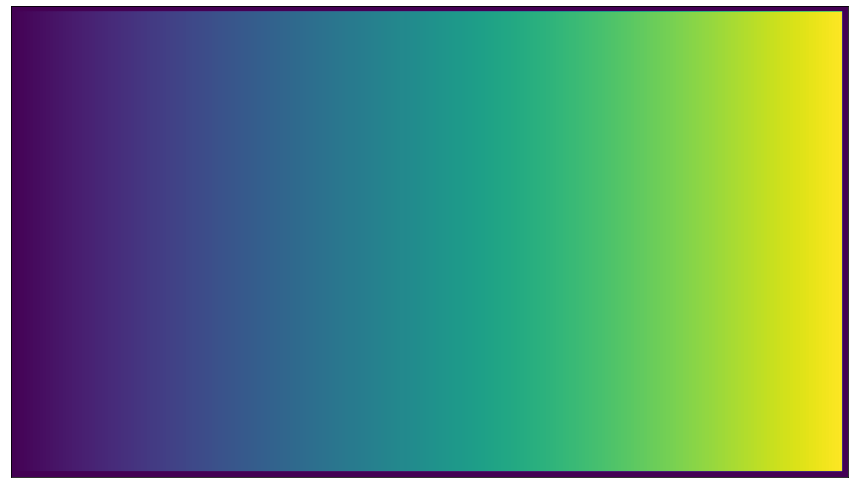

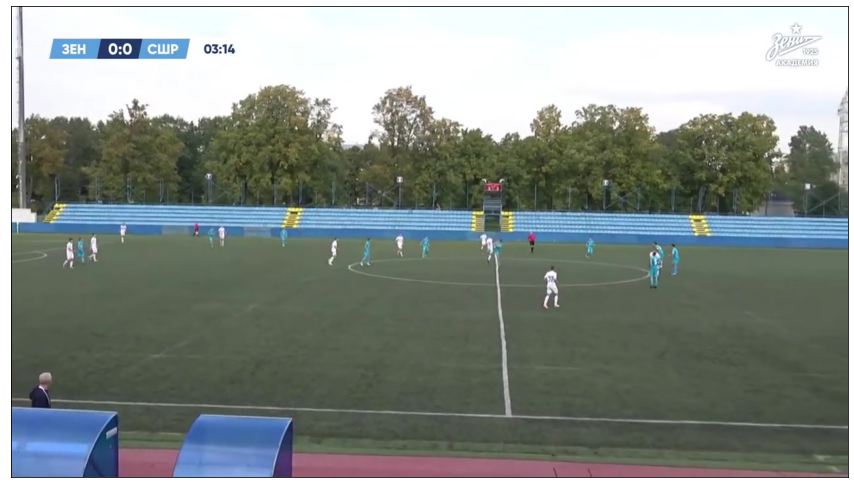

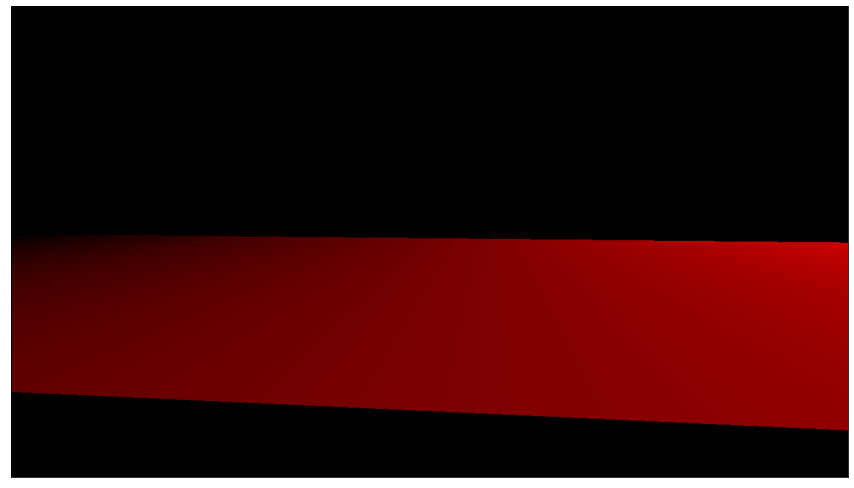

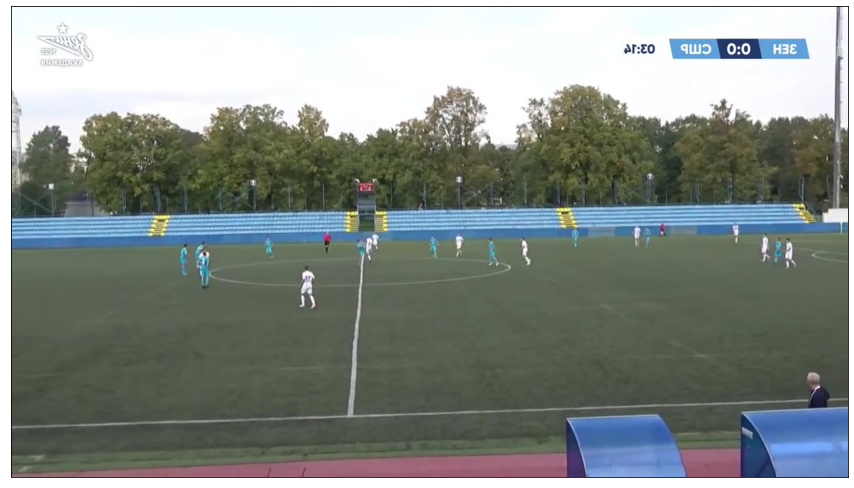

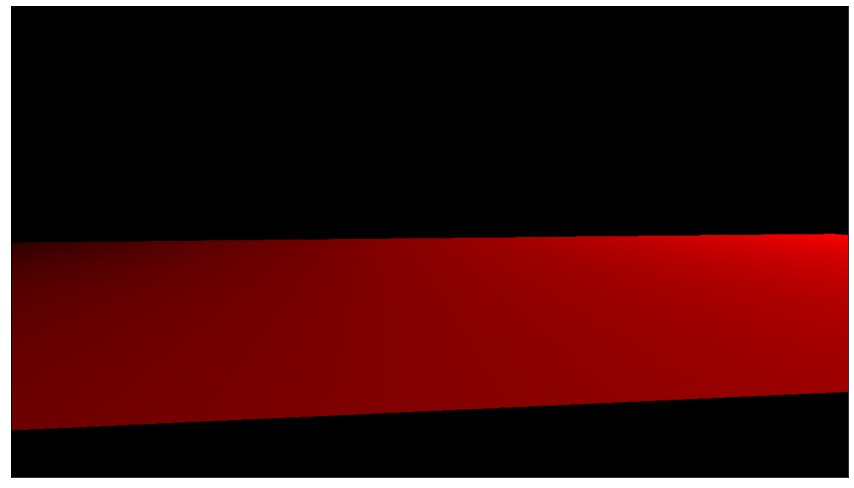

In [13]:
img_path = '/home/darkalert/Desktop/Sota/soccer/data/homography/datasets/train_2022/frames/PSPb_SSHOR-Zenit_vs_Zenit_U-15/img-00010.jpeg'
img = cv2.imread(img_path, -1)

path = '/home/darkalert/Desktop/Sota/soccer/data/homography/datasets/train_2022/masks_uv/PSPb_SSHOR-Zenit_vs_Zenit_U-15/img-00010.tif'
uv_mask = cv2.imread(path, -1)

mask = (uv_mask[:,:,0] / float(uv_mask[:,:,0].max())).astype(np.float32)
u = (uv_mask[:,:,1] / float(MAX_VALUE_UINT16)).astype(np.float32)
v = (uv_mask[:,:,2] / float(MAX_VALUE_UINT16)).astype(np.float32)
uv_mask = np.stack((mask, u, v), axis=2)


u_flip = cv2.flip(u, 1)
u_flip = (u_flip > 0).astype(u_flip.dtype) - u_flip

print (u.min(), u.max())
print (u_flip.min(), u_flip.max())


img_flip = cv2.flip(img, 1)

u = (u*255.0).astype(np.uint8)
u_flip = (u_flip*255.0).astype(np.uint8)
u = np.expand_dims(u, 2)
u_flip = np.expand_dims(u_flip, 2)
u = np.concatenate((u*0,u*0,u),2)
u_flip = np.concatenate((u_flip*0,u_flip*0,u_flip),2)

show(U_TEMPLATE)
show(img)
show(u)
show(img_flip)
show(u_flip)

**10. Move TEST-DATA to another folder**

In [73]:
TEST_DATA_DIR = '/media/darkalert/c02b53af-522d-40c5-b824-80dfb9a11dbb/sota/football/datasets/test-new'
TEST_GAMES = ['VTB_mol_Sochi_at_Dinamo', 'FNL_KubanKholding_at_DinamoMh', 'RPL_CSKA_at_Dinamo', 'Football_Forte_at_Dinamo']

!rm -r $TEST_DATA_DIR
!mkdir $TEST_DATA_DIR
!mkdir $TEST_DATA_DIR/frames
!mkdir $TEST_DATA_DIR/masks_rgb
!mkdir $TEST_DATA_DIR/masks
!mkdir $TEST_DATA_DIR/masks_uv
!mkdir $TEST_DATA_DIR/anno
!mkdir $TEST_DATA_DIR/debug
!mkdir $TEST_DATA_DIR/debug_uv

for game in TEST_GAMES:
    !mv $FRAMES_DIR/$game $TEST_DATA_DIR/frames/$game
    !mv $MASKS_DIR/$game $TEST_DATA_DIR/masks_rgb/$game
    !mv $ONEHOT_DIR/$game $TEST_DATA_DIR/masks/$game
    !mv $MASK_UV_DIR/$game $TEST_DATA_DIR/masks_uv/$game
    !mv $LABELS_DIR/$game $TEST_DATA_DIR/anno/$game
    !mv $DEBUG_DIR/$game $TEST_DATA_DIR/debug/$game
    !mv $DEBUG_UV_DIR/$game $TEST_DATA_DIR/debug_uv/$game
    
print ('Moved!')

Moved!


**==========================================All done!====================================================**

**ADDITIONAL: Convert the Narya keypoint-dataset to our format**

In [6]:
#!pip3 install xmltodict
import xmltodict

MAP_POI_ORDER_NARYA_TO_OUR = {
    '0': '0', '1': '1', '2': '8', '3': '2', '4': '6', '5': '3', '6': '7', '7': '4', \
    '8': '11', '9': '5', '10': '14', '11': '16', '12': '18', '13': '27', '14': '28', \
    '15': '21', '16': '29', '17': '25', '18': '30', '19': '26', '20': '31', '21': '24', \
    '22': '32', '23': '9', '24': '10', '25': '15', '26': '17', '27': '22', '28': '23'
}

def convert_narya_keypoints_dataset_to_our(src_img_dir, src_anno_dir, dst_img_dir, dst_anno_dir):
    src_names = [name.split('.xml')[0] for name in os.listdir(src_anno_dir) if name.endswith('.xml')]
    labels = {}
    counter = 0
    
    if not os.path.exists(dst_anno_dir):
        os.makedirs(dst_anno_dir)
    if not os.path.exists(dst_img_dir):
        os.makedirs(dst_img_dir)
    
    for src_name in src_names:
        dst_name = str(counter+1).zfill(6)
        
        src_img_path = os.path.join(src_img_dir, src_name + '.jpg')
        dst_img_path = os.path.join(dst_img_dir, dst_name + '.jpeg')
        src_anno_path = os.path.join(src_anno_dir, src_name + '.xml')
        dst_anno_path = os.path.join(dst_anno_dir, dst_name + '.json')
        
        if not os.path.isfile(src_img_path) or not os.path.isfile(src_anno_path):
            print ('Skipping {}...'.format(src_name))
            continue
        
        # Open XML:
        with open(src_anno_path, 'r') as f:
            data = dict(xmltodict.parse(f.read()))
            
        # Parse XML and convert POI format:
        width = int(data['annotation']['size']['width'])
        height = int(data['annotation']['size']['height'])
        poi = [(-1,-1)]*NUM_POI
        
        if type(data['annotation']['object']) is not list:
            data['annotation']['object'] = [data['annotation']['object']]

        for v in data['annotation']['object']:
            x = float(v['keypoints']['x1']) / width
            y = float(v['keypoints']['y1']) / height
            src_idx = v['name']
            dst_idx = int(MAP_POI_ORDER_NARYA_TO_OUR[src_idx])
            poi[dst_idx] = (x, y)

        labels[dst_name] = {
            'theta': None,
            'poi': poi,
            'elapsed': 0
        }
        
        # Open, resize and save an image:
        img = cv2.imread(src_img_path, 1)
        img = cv2.resize(img, FRAME_SIZE, interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(dst_img_path, img, [cv2.IMWRITE_JPEG_QUALITY, 95])
        
        counter += 1
    
    # Save output JSON:
    dst_anno_path = os.path.join(dst_anno_dir, 'manual_anno.json')
    with open(dst_anno_path, 'w') as f:
        json.dump(labels, f, cls=NumpyEncoder, indent=2)
        
    print ('All done! Total files:', counter)

In [7]:
# Convert Narya-keypoints-dataset-train anno to our:
src_img_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/keypoints/train/JPEGImages'
src_anno_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/keypoints/train/Annotations'
dst_img_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya/frames/narya-keypoints-train'
dst_anno_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya/manual_anno/narya-keypoints-train'

convert_narya_keypoints_dataset_to_our(src_img_dir, src_anno_dir, dst_img_dir, dst_anno_dir)


# Convert Narya-keypoints-dataset-test anno to our:
src_img_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/keypoints/test/JPEGImages'
src_anno_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/keypoints/test/Annotations'
dst_img_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya/frames/narya-keypoints-test'
dst_anno_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya/manual_anno/narya-keypoints-test'

convert_narya_keypoints_dataset_to_our(src_img_dir, src_anno_dir, dst_img_dir, dst_anno_dir)

Skipping img_BL_6...
All done! Total files: 507
All done! Total files: 58


**Visualize Narya keypoints-dataset sample**

In [ ]:
def viz_narya_keypoints_sample(anno_path, img_path):
    # Open XML:
    with open(anno_path, 'r') as f:
        data = dict(xmltodict.parse(f.read()))

    # Parse XML and convert POI format:
    width = int(data['annotation']['size']['width'])
    height = int(data['annotation']['size']['height'])
    poi = [(-1,-1)]*NUM_POI

    if type(data['annotation']['object']) is not list:
        data['annotation']['object'] = [data['annotation']['object']]

    for v in data['annotation']['object']:
        x = float(v['keypoints']['x1']) / width
        y = float(v['keypoints']['y1']) / height
        src_idx = v['name']
        dst_idx = int(MAP_POI_ORDER_NARYA_TO_OUR[src_idx])
        poi[dst_idx] = (x, y)

    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, FRAME_SIZE, interpolation=cv2.INTER_CUBIC)
    img = draw_poi(img, poi)

    print (poi)
    plt.title('img')
    plt.imshow(img[...,::-1])
    plt.show()
    
    
anno_path = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/keypoints/train/Annotations/wc_73.xml'
img_path = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/keypoints/train/JPEGImages/wc_73.jpg'
viz_narya_keypoints_sample(anno_path, img_path)

**==============================================================================================**

**ADDITIONAL 2: Convert the Narya homography-dataset to our format**

In [9]:
def convert_narya_homography_dataset_to_our(src_img_dir, src_homo_dir, dst_img_dir, dst_anno_dir):
    # Open field PoI:
    field_poi = load_court_poi(FIELD_POI_PATH, normalize=False)
    field_poi = np.expand_dims(field_poi, 0)
    field_poi = field_poi - 0.5    # normalize like 
    
    src_names = [name.split('_homo.npy')[0] for name in os.listdir(src_homo_dir) if name.endswith('.npy')]
    labels = {}
    counter = 0
    
    if not os.path.exists(dst_anno_dir):
        os.makedirs(dst_anno_dir)
    if not os.path.exists(dst_img_dir):
        os.makedirs(dst_img_dir)
    
    for src_name in src_names:
        dst_name = str(counter+1).zfill(6)
        
        src_img_path = os.path.join(src_img_dir, src_name + '.jpg')
        dst_img_path = os.path.join(dst_img_dir, dst_name + '.jpeg')
        src_homo_path = os.path.join(src_homo_dir, src_name + '_homo.npy')
        dst_anno_path = os.path.join(dst_anno_dir, dst_name + '.json')
        
        if not os.path.isfile(src_img_path) or not os.path.isfile(src_homo_path):
            print ('Skipping {}...'.format(src_name))
            continue
        
        # Open source homography:
        theta = np.load(src_homo_path)
        if theta.ndim > 2:
            theta = theta[0]
        theta_inv = np.linalg.inv(theta)
        
        # Transform field PoI:
        poi = cv2.perspectiveTransform(field_poi, theta_inv)[0]
        poi = poi + 0.5

#         # Leave only visible PoI:
#         for i,(x,y) in enumerate(poi):
#             if x < 0 or x >= 1.0 or y < 0 or y >= 1.0:
#                 poi[i] = (-1,-1)
        
        # Open, resize and save an image:
        img = cv2.imread(src_img_path, 1)
        H, W = img.shape[:2]
        img = cv2.resize(img, FRAME_SIZE, interpolation=cv2.INTER_CUBIC)
        cv2.imwrite(dst_img_path, img, [cv2.IMWRITE_JPEG_QUALITY, 95])
        
        # Due to the fact that the homography is inaccurate and it is impossible 
        # to calculate the RMSE, we add a fake RMSE to reduce the weights of these 
        # samples during training:
        fake_rmse = 5.0
        if W == 1024 and H == 1024:
            fake_rmse += 2.0
        if W == 180 and H == 360:
            fake_rmse += 5.0
        
        labels[dst_name] = {
            'theta': None,
            'poi': poi,
            'elapsed': 0,
            'rmse': fake_rmse
        }
        
        counter += 1
    
    # Save output JSON:
    dst_anno_path = os.path.join(dst_anno_dir, 'manual_anno.json')
    with open(dst_anno_path, 'w') as f:
        json.dump(labels, f, cls=NumpyEncoder, indent=2)
        
    print ('All done! Total files:', counter)

In [10]:
# Convert Narya-homography-dataset-train anno to our:
src_img_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/homography/train_img'
src_homo_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/homography/train_homo'
dst_img_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya/frames/narya-homography-train'
dst_anno_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya/manual_anno/narya-homography-train'

convert_narya_homography_dataset_to_our(src_img_dir, src_homo_dir, dst_img_dir, dst_anno_dir)


# Convert Narya-homography-dataset-test anno to our:
src_img_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/homography/test_img'
src_homo_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/homography/test_homo'
dst_img_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya/frames/narya-homography-test'
dst_anno_dir = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya/manual_anno/narya-homography-test'

convert_narya_homography_dataset_to_our(src_img_dir, src_homo_dir, dst_img_dir, dst_anno_dir)

All done! Total files: 873
All done! Total files: 158


**Visualize Narya homography-dataset sample**

In [ ]:
def viz_narya_homography_sample(homo_path, img_path):
    # Open field PoI:
    field_poi = load_court_poi(FIELD_POI_PATH, normalize=False)
    field_poi = np.expand_dims(field_poi, 0)
    field_poi = field_poi - 0.5    # normalize like narya

    # Open image:
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, FRAME_SIZE, interpolation=cv2.INTER_CUBIC)

    # Open homography:
    theta = np.load(homo_path)
    if theta.ndim > 2:
        theta = theta[0]
    theta_inv = np.linalg.inv(theta)

    # Transform PoI:
    poi = cv2.perspectiveTransform(field_poi, theta_inv)[0]
    poi = poi + 0.5
    
#     # Leave only visible PoI:
#     for i,(x,y) in enumerate(poi):
#         if x < 0 or x >= 1.0 or y < 0 or y >= 1.0:
#             poi[i] = (-1,-1)

    # Draw and show:
    img = draw_poi(img, poi)
    plt.title('img')
    plt.imshow(img[...,::-1])
    plt.show()

img_path = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/homography/train_img/100.jpg'
homo_path = '/home/darkalert/Desktop/Sota/soccer/data/homography/anno/narya_tracker/homography/train_homo/100_homo.npy'
viz_narya_homography_sample(homo_path, img_path)